# Test Various CNN architectures on the layer identification task


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from models.Classifier_models import CNN1D_Small, CNN1D_Large, train_model
from models.utils import identify_device

## Import Data 

In [2]:
device = identify_device()

Using device: cuda


In [3]:
# Load the dataset with weights_only=False
data = torch.load("Synthetic_data_60k.pt", weights_only=False)

# Extract components
synthetic_data = data["synthetic_data"]
material_params = data["material_params"]
num_layers = data["num_layers"]

print("Dataset loaded successfully!")
print(f"Number of samples: {len(synthetic_data)}")
print(f"Shape of synthetic_data: {synthetic_data.shape}")
print(f"Shape of num_layers: {num_layers.shape}")
print(f"Example number of layers: {num_layers[:10]}")

num_classes = int(max(num_layers)) # class labels start at 1 not 0.

Dataset loaded successfully!
Number of samples: 60000
Shape of synthetic_data: torch.Size([60000, 1024])
Shape of num_layers: torch.Size([60000])
Example number of layers: tensor([3, 3, 2, 1, 3, 2, 3, 1, 1, 3])


In [4]:
# Adjust labels for training (CrossEntropyLoss expects 0-based class labels)
num_layers_adjusted = num_layers - 1  # Convert labels from 1–5 → 0–4

# Ensure shapes are as expected
print("synthetic_data shape (after unsqueeze):", synthetic_data.unsqueeze(1).shape)
print("num_layers (original):", num_layers[:10])
print("num_layers_adjusted (for training):", num_layers_adjusted[:10])


synthetic_data shape (after unsqueeze): torch.Size([60000, 1, 1024])
num_layers (original): tensor([3, 3, 2, 1, 3, 2, 3, 1, 1, 3])
num_layers_adjusted (for training): tensor([2, 2, 1, 0, 2, 1, 2, 0, 0, 2])


In [5]:
num_classes = int(num_layers_adjusted.max().item()) + 1  # e.g., 5 if max label is 4
batch_size = 256

# Unsqueeze to add channel dimension for Conv1D input: [B, 1, 1024]
synthetic_data = synthetic_data.unsqueeze(1)  # [100, 1, 1024]

# Create TensorDataset with adjusted labels
train_dataset = TensorDataset(synthetic_data, num_layers_adjusted)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Train and Test Small CNN

In [6]:
# Initialize the model, criterion, and optimizer
model = CNN1D_Small(input_channels=1, num_classes=num_classes).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Optional: Print shapes and label stats for sanity check
print("Data shape:", synthetic_data.shape)
print("Label range:", num_layers_adjusted.min().item(), "to", num_layers_adjusted.max().item())
print("Number of classes:", num_classes)

Data shape: torch.Size([60000, 1, 1024])
Label range: 0 to 2
Number of classes: 3


Training: 100%|██████████| 250/250 [05:22<00:00,  1.29s/epoch]


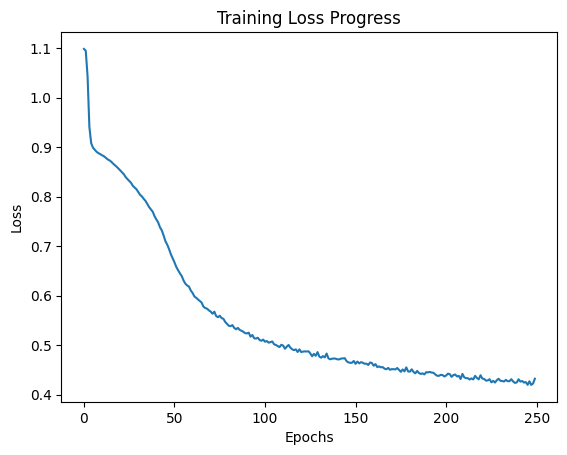

In [7]:
# Train the model
loss_values, accuracy_values = train_model(model, train_loader, criterion, optimizer, device=device, num_epochs=250)

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.show()

In [ ]:
# Plot the acuracy values
plt.plot(accuracy_values)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy Progress')
plt.show()


 Unseen dataset Accuracy: 0.8180


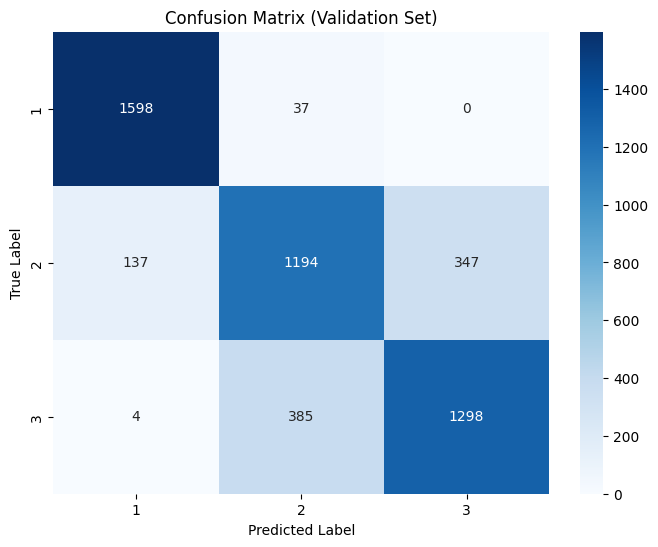

In [8]:
# Load the validation dataset
val_data = torch.load("Validation.pt", weights_only=False)

val_synthetic_data = val_data["synthetic_data"]         # shape: [N, 1024]
val_num_layers = val_data["num_layers"]                 # shape: [N]
val_num_layers_adjusted = val_num_layers - 1            # match training label indexing

# Unsqueeze to match model input shape
val_synthetic_data = val_synthetic_data.unsqueeze(1)    # shape: [N, 1, 1024]

# Create DataLoader for validation
val_dataset = TensorDataset(val_synthetic_data, val_num_layers_adjusted)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


model.eval()
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())   # move back to CPU before numpy
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix and accuracy
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)

print(f"\n Unseen dataset Accuracy: {acc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{i+1}" for i in range(cm.shape[0])],
            yticklabels=[f"{i+1}" for i in range(cm.shape[0])])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

## Train and test Larger CNN

In [9]:
batch_size = 256

# Create TensorDataset with adjusted labels
train_dataset = TensorDataset(synthetic_data, num_layers_adjusted)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
# TODO: Learning rate annealing

# Initialize the model, criterion, and optimizer
model = CNN1D_Large(input_channels=1, num_classes=num_classes).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Optional: Print shapes and label stats for sanity check
print("Data shape:", synthetic_data.shape)
print("Label range:", num_layers_adjusted.min().item(), "to", num_layers_adjusted.max().item())
print("Number of classes:", num_classes)

Data shape: torch.Size([60000, 1, 1024])
Label range: 0 to 2
Number of classes: 3


Training: 100%|██████████| 150/150 [08:45<00:00,  3.50s/epoch]


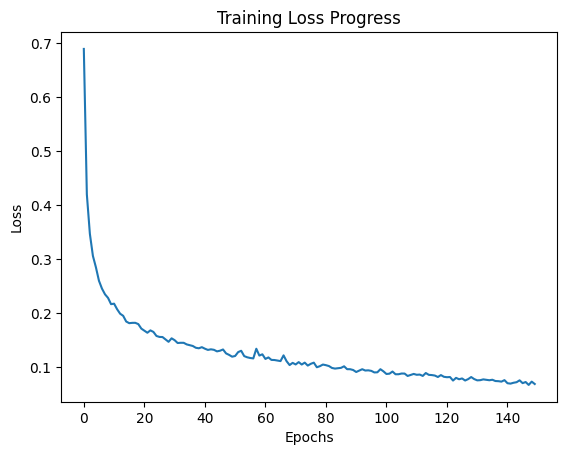

In [11]:
# Train the model
loss_values, accuracy_values = train_model(model, train_loader, criterion, optimizer, device=device, num_epochs=150)

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.show()

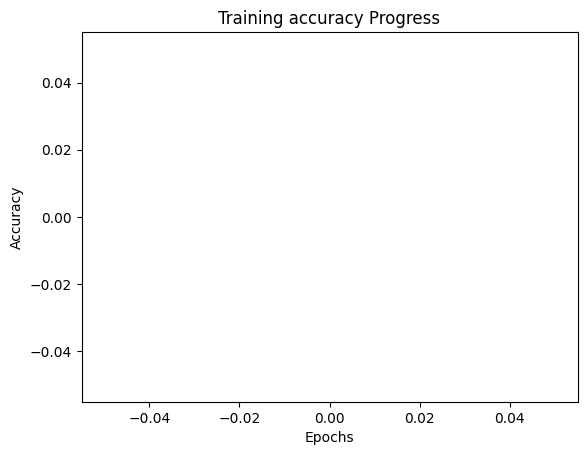

In [12]:
# Plot the acuracy values
plt.plot(accuracy_values)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy Progress')
plt.show()


Unseen Accuracy: 0.6482


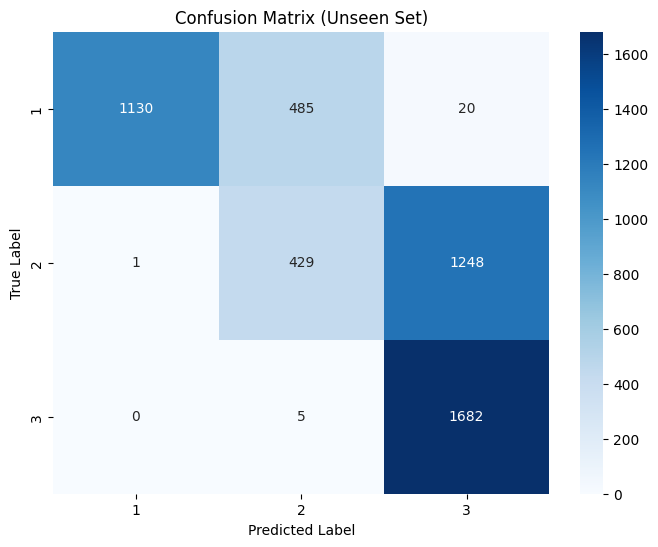

In [13]:
# Load the validation dataset
val_data = torch.load("Validation.pt", weights_only=False)

val_synthetic_data = val_data["synthetic_data"]         # shape: [N, 1024]
val_num_layers = val_data["num_layers"]                 # shape: [N]
val_num_layers_adjusted = val_num_layers - 1            # match training label indexing

# Unsqueeze to match model input shape
val_synthetic_data = val_synthetic_data.unsqueeze(1)    # shape: [N, 1, 1024]

# Create DataLoader for validation
val_dataset = TensorDataset(val_synthetic_data, val_num_layers_adjusted)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Set model to evaluation mode
model.eval()
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())   # move back to CPU before numpy
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix and accuracy
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)

print(f"\nUnseen Accuracy: {acc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{i+1}" for i in range(cm.shape[0])],
            yticklabels=[f"{i+1}" for i in range(cm.shape[0])])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Unseen Set)")
plt.show()